In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split

import torch

import seaborn as sns

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

from tqdm.autonotebook import tqdm

from IPython.display import clear_output

c:\Users\30694\Desktop\DTU\MBML\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = Path('../data/processed/data_processed.csv')

data = pd.read_csv(data_path.as_posix())

In [3]:
data.columns

Index(['Unnamed: 0', 'machineID', 'datetime', 'voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count', 'comp1', 'comp2', 'comp3',
       'comp4', 'comp1_life', 'comp2_life', 'comp3_life', 'comp4_life', 'age',
       'model_model1', 'model_model2', 'model_model3', 'model_model4',
       'failure', 'comp1_fail', 'comp2_fail', 'comp3_fail', 'comp4_fail'],
      dtype='object')

In [4]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.dropna(axis=0, inplace=True)

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'])

Try linear regression with one target variable, the continuous variable `comp1_life`:

In [6]:
cols = ['voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count','age',
       'model_model1', 'model_model2', 'model_model3', 'model_model4','comp2_life']

data_tst = data[cols]

In [7]:
data_tst.shape

(4409, 27)

In [8]:
X = data_tst.to_numpy()

# Keep the last column as target y
y = X[:,-1]
X = X[:,:-1]

In [9]:
def heteroscedastic_model(X, obs=None):
    alpha_mu = pyro.sample("alpha_mu", dist.Normal(0., 1.))                 # Prior for the bias/intercept of the mean
    beta_mu  = pyro.sample("beta_mu", dist.Normal(torch.zeros(X.shape[1]), 
                                               torch.ones(X.shape[1])).to_event())     # Priors for the regression coeffcients of the mean
    alpha_v = pyro.sample("alpha_v", dist.Normal(0., 1.))                   # Prior for the bias/intercept of the variance
    beta_v  = pyro.sample("beta_v", dist.Normal(torch.zeros(X.shape[1]), 
                                               torch.ones(X.shape[1])).to_event())     # Priors for the regression coeffcients of the variance
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha_mu + X.matmul(beta_mu), torch.exp(alpha_v + X.matmul(beta_v))), obs=obs)
        
    return y

In [10]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std
print(X.shape)

(4409, 26)


In [11]:
# standardize pickups
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std
print(y.shape)

(4409,)


In [12]:
train_perc = 0.80 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]

print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 3527
num test: 882


In [13]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [14]:
# Prepare data for Pyro model
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (3527, 26)
y_train shape: (3527,)


In [15]:
# Define guide function
guide = AutoDiagonalNormal(heteroscedastic_model)

# Reset parameter values
pyro.clear_param_store()

In [16]:
# Define the number of optimization steps
n_steps = 40000

# Setup the optimizer
adam_params = {"lr": 0.0001} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(heteroscedastic_model, guide, optimizer, loss=elbo)

In [17]:
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 4982589.3
[1000] ELBO: 42214.3
[2000] ELBO: 18967.2
[3000] ELBO: 12857.4
[4000] ELBO: 6897.5
[5000] ELBO: 5963.4
[6000] ELBO: 6134.0
[7000] ELBO: 5209.3
[8000] ELBO: 5987.0
[9000] ELBO: 5561.3
[10000] ELBO: 4804.3
[11000] ELBO: 4895.5
[12000] ELBO: 4413.2
[13000] ELBO: 4168.5
[14000] ELBO: 4015.2
[15000] ELBO: 4234.1
[16000] ELBO: 4058.2
[17000] ELBO: 3913.2
[18000] ELBO: 4265.8
[19000] ELBO: 3855.4
[20000] ELBO: 3644.0
[21000] ELBO: 3990.6
[22000] ELBO: 4394.7
[23000] ELBO: 3514.0
[24000] ELBO: 3606.5
[25000] ELBO: 3258.7
[26000] ELBO: 3607.4
[27000] ELBO: 3206.3
[28000] ELBO: 3653.1
[29000] ELBO: 3030.8
[30000] ELBO: 3375.2
[31000] ELBO: 3672.9
[32000] ELBO: 3043.9
[33000] ELBO: 3078.3
[34000] ELBO: 3398.1
[35000] ELBO: 2859.6
[36000] ELBO: 2925.6
[37000] ELBO: 3294.2
[38000] ELBO: 3621.3
[39000] ELBO: 2999.3


In [22]:
from pyro.infer import Predictive

predictive = Predictive(heteroscedastic_model, guide=guide, num_samples=1000,
                        return_sites=("alpha_mu", "beta_mu", "alpha_v", "beta_v"))
samples = predictive(X_train_torch, y_train_torch)

In [23]:
y_std, y_mean

(32.31119200171958, 24.552959854842367)

In [25]:
alpha_samples = samples["alpha_mu"].detach().numpy()
beta_samples = samples["beta_mu"].detach().numpy()
y_hat = np.mean(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T), axis=1)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.559
MAE: 16.517
RMSE: 27.985
R2: 0.293


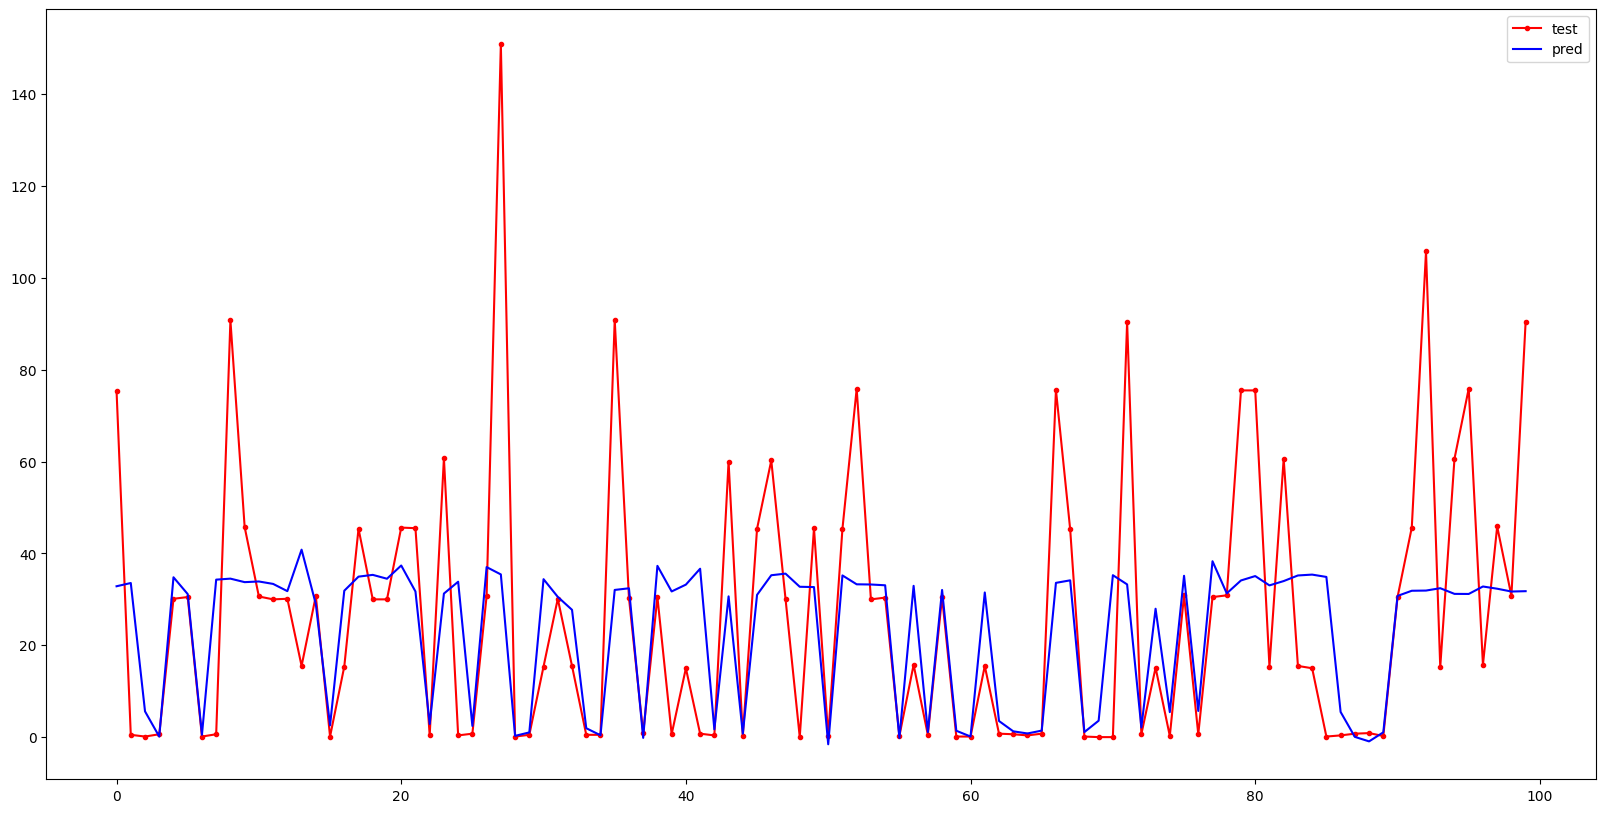

In [26]:
fig = plt.figure(figsize=(20, 10))

start = 300
end = 400

plt.plot(y_true[start:end], 'r.-', label='test')
plt.plot(preds[start:end], 'b-', label='pred')

plt.legend()

plt.show()

NameError: name 'preds_train' is not defined

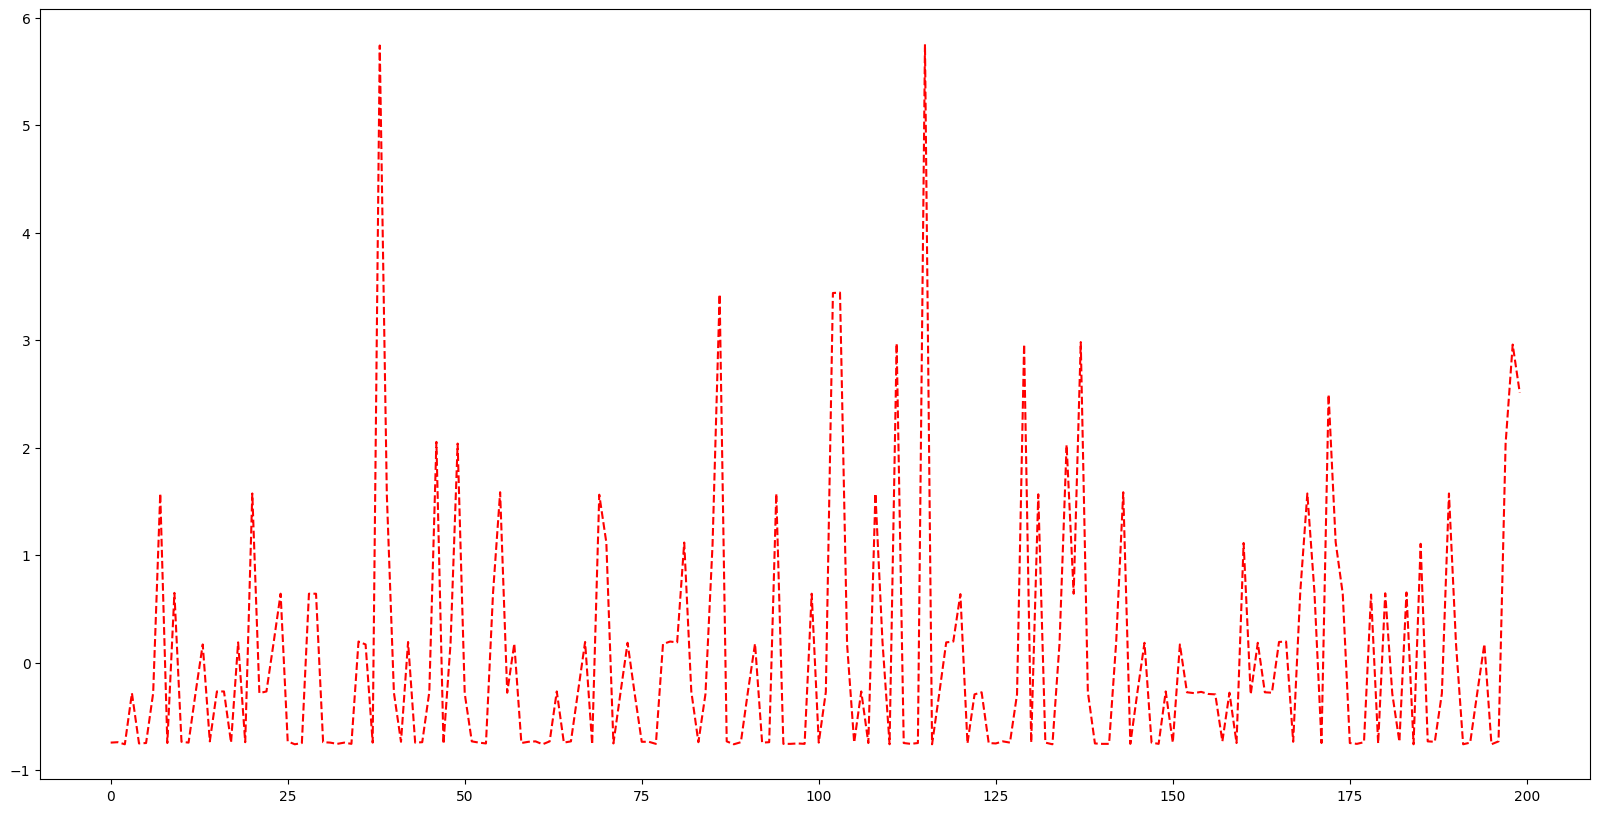

In [28]:
fig = plt.figure(figsize=(20, 10))

start = 400
end = 600

plt.plot(y_test[start:end], 'r--', label='train')
plt.plot(preds_train[start:end], 'b-', label='pred')

plt.legend()

plt.show()